**Authors:** Jozef Hanč, Martina Hančová <br> *[Faculty of Science](https://www.upjs.sk/en/faculty-of-science/?prefferedLang=EN), P. J. Šafárik University in Košice, Slovakia* <br> emails: [martina.hancova@upjs.sk](mailto:martina.hancova@upjs.sk)
***

# <font color = brown, size=6> DE quadrature for convolution and numerical inversion <br> $\mathcal{GDD}$ pdf calculations</font>

<font size=4> Computational tools: </font>  **<font size=4>Python, Numba</font>**  

In [1]:
N = 4 #test up to 10^N

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from numpy import inf as INF
from time import time
from numpy import array as v

import math, cmath
import scipy

# approximate formulas for precisions expressed in bits and decimal places
bits = lambda d:round((d+1)*ln(10)/ln(2)) 
dps = lambda b:round(b*ln(2)/ln(10) - 1)

# accuracy in Python
def abs_errs(df1, df2):
    N = len(df1)
    errors = [abs(df1[i]-df2[i]) for i in range(N)]
    return errors

In [2]:
scipy.__version__, np.__version__, pd.__version__

('1.6.0', '1.19.2', '1.2.3')

# Pdf computation

## Pdf via analytic expression

$
f(z)=
\dfrac{\beta_{1}^{\alpha_{1}} \beta_{2}^{\alpha_{2}}}{\beta^{\alpha-1}}
\begin{cases}
{\dfrac{e^{z \beta_{2}}}{\Gamma\left(\alpha_{2}\right)} U\left(1-\alpha_{2}, 2-\alpha,-z \beta\right),} & {z<0} \\[12pt]
\begin{array}{cc} 
\frac{\Gamma(\alpha-1)}{\beta^{a / 2-1} \Gamma\left(\alpha_{1}\right) \Gamma\left(\alpha_{2}\right)}, & \scriptstyle 1<\alpha \\ 
\infty,  & \scriptstyle 0<\alpha \leq 1 
\end{array}, & z=0 \\[12pt] 
{\dfrac{e^{-z \beta_{1}}}{\Gamma\left(\alpha_{1}\right)} U\left(1-\alpha_{1}, 2-\alpha, z \beta\right),} & {z>0}
\end{cases}
$


$\alpha=\alpha_{1}+\alpha_{2}, \quad \beta=\beta_{1}+\beta_{2}$

In [4]:
# pre-calculated all values
dpari = {str(10**(n+1)):np.loadtxt('data/Pari_Sage_pdf'+str(10**(n+1))+'.txt', delimiter=',',
                                    dtype=np.longdouble) for n in range(N)}

## Pdf convolution via DE

$
f(z)=
\dfrac{\beta_{1}^{\alpha_{1}} \beta_{2}^{\alpha_{2}}}{\Gamma\left(\alpha_{1}\right) \Gamma\left(\alpha_{2}\right)}
\begin{cases}
{e^{-\beta_{1} z} \displaystyle \int_{-z}^{\infty} x^{\alpha_{2}-1}(x+z)^{\alpha_{1}-1} e^{-\beta x} d x,} & {z<0} \\[12pt]
\begin{array}{cc} 
\frac{\Gamma(\alpha-1)}{\beta^{a-1}}, & \scriptstyle 1<\alpha \\ 
\infty,  & \scriptstyle 0<\alpha \leq 1 
\end{array}, & z=0 \\[12pt] 
{e^{\beta_{2} z} \displaystyle \int_{z}^{\infty} x^{\alpha_{1}-1}(x-z)^{\alpha_{2}-1} e^{-\beta x} d x,} & {z>0}
\end{cases}
$

$\alpha=\alpha_{1}+\alpha_{2}, \quad \beta=\beta_{1}+\beta_{2}$

In [5]:
import scipy.special as sp
from TRandDE.DEQuadratureNumba import *
from TRandDE.DEQuadrature import *

## Setting parameters and integrands

In [6]:
# parameters
eps = 1e-8
a1, b1, a2, b2 = 0.5, 1.0, 8.5, 93.0
a, b = a1+a2, b1+b2
c = b1**a1*b2**a2/(sp.gamma(a1)*sp.gamma(a2))
cc = c*sp.gamma(a-1)/b**(a-1)

In [7]:
# Python integrands
def gm(x,z):
    if x == -z:
        value = c*math.exp(-z*b1)*x**(a2-1)*(1e-16)**(a1-1)*math.exp(-b*x)
    if x > -z:
        value = c*math.exp(-z*b1)*x**(a2-1)*(x+z)**(a1-1)*math.exp(-b*x)
    return value

def gp(x,z):
    return c*math.exp(z*b2)*x**(a1-1)*(x-z)**(a2-1)*math.exp(-b*x)

In [8]:
# Numba integrands
@njit(fastmath=True)
def gmn(x,z):
    if x == -z:
        value = c*math.exp(-z*b1)*x**(a2-1)*(1e-16)**(a1-1)*math.exp(-b*x)
    if x > -z:
        value = c*math.exp(-z*b1)*x**(a2-1)*(x+z)**(a1-1)*math.exp(-b*x)
    return value

@njit(fastmath=True)
def gpn(x,z):
    return c*math.exp(z*b2)*x**(a1-1)*(x-z)**(a2-1)*math.exp(-b*x)

## Convolution integrals

In [10]:
# DE Python
def fconde(z, eps_rel = eps):
    if z<0:
        value = intdei(lambda x:gm(x,z), -z,  eps_rel)[0]
    elif z>0:
        value = intdei(lambda x:gp(x,z), z, eps_rel)[0]
    else:
        value = cc
    return value

In [11]:
# DE numba, factory function
intdeim = make_intdei(gmn)
intdeip = make_intdei(gpn)

def fconden(z, eps_rel = eps):
    if z<0:
        value = intdeim(-z, z, eps_rel)[0] 
    elif z>0:
        value = intdeip(z, z, eps_rel)[0]
    else:
        value = cc
    return value

In [12]:
fconde(-0.06), fconden(-0.06)

(3.3942737449515605, 3.3942737449515605)

## Pdf numerical inversion via DE
<div style="display:none">
$
 \newcommand{\a}{\alpha}
 \newcommand{\b}{\beta}
 \newcommand{\cft}{\varphi(t)}
 \newcommand{\Rv}[1]{\mathscr{R}^{#1}}
$
</div>

**<font size=3>Complex numbers $\mathcal{C}$ </font>** 
$$\large f(x)=  \frac{1}{\pi} 
\int_0^\infty \Re \left[e^{-itx}\cft\right]dt 
$$

$$ 
\cft=  \left(1-\dfrac{it}{\b_1}\right)^{-\a_1}\left(1+\dfrac{it}{\b_2}\right)^{-\a_2}, t\in \Rv{}
$$

**<font size=3>Real numbers $\mathcal{R}$ </font>** 
$$
\large f(x)= \int_{0}^{\infty} g(x,t) dt 
$$

$$ 
g(x,t) = r(t)\cos(xt-\phi(t)), 
$$

$$ r(t)= \frac{\b_1^{\a_1} \b_2^{\a_2}}{\pi\left(\b_1^2+t^2\right)^{\a_1/2}
\left(\b_2^2+t^2\right)^{\a_2 / 2}}, \quad \phi(t) = \a_1 \arctan \frac{t}{\b_1}-\a_2 \arctan \frac{t}{\b_2}$$

## Setting parameters and integrands

In [13]:
# Setting parameters and integrands
d = b1**a1*b2**a2/math.pi

In [14]:
# integrand Python, complex functions
def gcpy(t, x):
    phit = (1-1j*t/b1)**(-a1)*(1+1j*t/b2)**(-a2)
    return (1/math.pi*cmath.exp(-1j*t*x)*phit).real

In [15]:
# integrand Numba
@njit(fastmath=True)
def gcn(t, x):
    phit = (1-1j*t/b1)**(-a1)*(1+1j*t/b2)**(-a2)
    return (1/math.pi*cmath.exp(-1j*t*x)*phit).real

@njit(fastmath=True)
def gn(t,x):
    phi = a1*math.atan(t/b1) - a2*math.atan(t/b2)
    r = 1/((b1*b1 + t*t)**(a1/2)*(b2*b2 + t*t)**(a2/2))
    return d*r*math.cos(x*t-phi)

## Numerical inversion integrals

In [16]:
# DE python, complex
fnumdec = lambda x, eps_rel = eps: intdeo(lambda t: gcpy(t,x), 0, x, eps)[0]

In [17]:
# DE numba
intdeogcn = make_intdeo(gcn)
intdeogn = make_intdeo(gn)

# numba, complex
fnumdecn = lambda x, eps_rel=eps: intdeogcn(0, x, eps)[0]

# numba, float
fnumden = lambda x, eps_rel=eps: intdeogn(0, x, eps)[0]

In [18]:
fnumdec(1), fnumdecn(1), fnumden(1)

(0.18154352688026298, 0.18154352688026335, 0.18154352688026396)

# Benchmark

## cross-checking: plots

In [19]:
methods = {'DE-conv':fconde, 'DE-conv-n': fconden, 
       'DE-numinv-c': fnumdec, 'DE-numinv-cn':fnumdecn,
       'DE-numin-n': fnumden}
pdf = {m:f for m,f in methods.items()}

In [20]:
points = np.linspace(-3, 4, 1000)

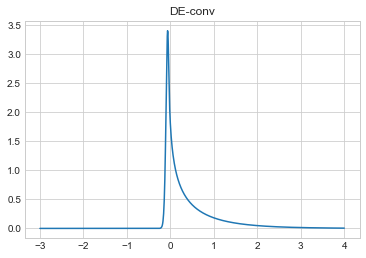

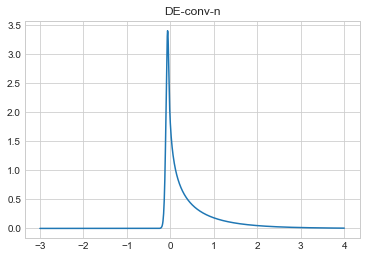

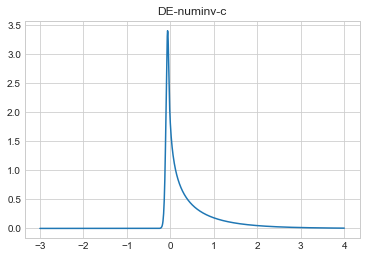

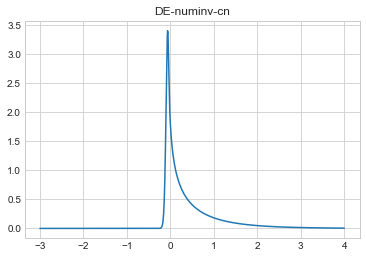

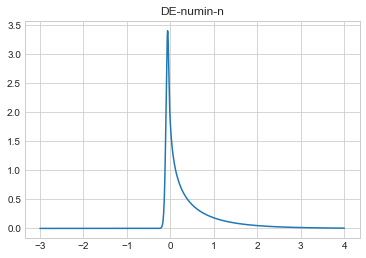

In [21]:
for method in list(pdf.keys()):
    yh = [pdf[method](u) for u in points]
    plt.plot(points,yh)
    plt.title(method)
    plt.show();

## Computation - one point $x=1$

In [22]:
t = 1
runtimes = dict()
for method, fun in pdf.items():
    print(method, type(fun(t)), 'f('+str(t)+')=', fun(t))
    rt = %timeit -r 3 -n 10 -oq fun(t)
    runtimes[method] = rt.average
    %timeit -r 3 -n 10 fun(t)
    print('')

DE-conv <class 'numpy.float64'> f(1)= 0.18154352175631908
192 µs ± 1.37 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)

DE-conv-n <class 'float'> f(1)= 0.1815435217563191
3.55 µs ± 151 ns per loop (mean ± std. dev. of 3 runs, 10 loops each)

DE-numinv-c <class 'float'> f(1)= 0.18154352688026298
119 µs ± 1.47 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)

DE-numinv-cn <class 'float'> f(1)= 0.18154352688026335
19.7 µs ± 277 ns per loop (mean ± std. dev. of 3 runs, 10 loops each)

DE-numin-n <class 'float'> f(1)= 0.18154352688026396
5.81 µs ± 178 ns per loop (mean ± std. dev. of 3 runs, 10 loops each)



In [23]:
for method, runtime in runtimes.items():
    print(f"{runtime*1e4:.3f}", method)

1.910 DE-conv
0.036 DE-conv-n
1.185 DE-numinv-c
0.373 DE-numinv-cn
0.058 DE-numin-n


In [24]:
ts = v(list(runtimes.values()))*10000
(max(ts)/ts).round(1)

array([ 1. , 53.8,  1.6,  5.1, 33. ])

## Computation - 10000 points $x \in (-3,4)$

In [25]:
benchmark = pd.DataFrame(index = range(3, 16), 
            columns = methods.keys())
benchmark.insert(0, 'err', v([f"{10**(-n):.0e}" for n in range(3, 16)]))

In [26]:
# points
x = lambda n: np.linspace(-3, 4, n)
# pre-calculated all values
dx = {str(10**(n+1)):np.loadtxt('data/xvalues'+str(10**(n+1))+'.txt', dtype=np.longdouble) for n in range(N)}

In [26]:
# start time
tic = time()
points = dx[str(10**N)]
for method, fun in methods.items():
    for n in range(3, 16):
        eps = 10**(-n)
        rt = %timeit -r 3 -n 3 -oq [fun(xh, eps) for xh in points]
        print(10**N, method, ' eps=', eps)
        dm = [fun(xh, eps) for xh in points]
        dp = dparis[str(10**N)]
        ch_abs = abs_errs(dm,dp)
        ch_rel = rel_errs(dm,dp)
        benchmark.at[n,method] = [rt.average, rt.stdev, min(ch_abs), max(ch_abs), min(ch_rel), max(ch_rel)] #stdev
    #end time
    toc = time()-tic; 
    print('runtime =',toc,'s')
    print(25*'*')

10000 DE-conv  eps= 0.001
10000 DE-conv  eps= 0.0001
10000 DE-conv  eps= 1e-05
10000 DE-conv  eps= 1e-06
10000 DE-conv  eps= 1e-07
10000 DE-conv  eps= 1e-08
10000 DE-conv  eps= 1e-09
10000 DE-conv  eps= 1e-10
10000 DE-conv  eps= 1e-11
10000 DE-conv  eps= 1e-12
10000 DE-conv  eps= 1e-13
10000 DE-conv  eps= 1e-14
10000 DE-conv  eps= 1e-15
runtime = 682.257447719574 s
*************************
10000 DE-conv-n  eps= 0.001
10000 DE-conv-n  eps= 0.0001
10000 DE-conv-n  eps= 1e-05
10000 DE-conv-n  eps= 1e-06
10000 DE-conv-n  eps= 1e-07
10000 DE-conv-n  eps= 1e-08
10000 DE-conv-n  eps= 1e-09
10000 DE-conv-n  eps= 1e-10
10000 DE-conv-n  eps= 1e-11
10000 DE-conv-n  eps= 1e-12
10000 DE-conv-n  eps= 1e-13
10000 DE-conv-n  eps= 1e-14
10000 DE-conv-n  eps= 1e-15
runtime = 690.2264873981476 s
*************************
10000 DE-numinv-c  eps= 0.001
10000 DE-numinv-c  eps= 0.0001
10000 DE-numinv-c  eps= 1e-05
10000 DE-numinv-c  eps= 1e-06
10000 DE-numinv-c  eps= 1e-07
10000 DE-numinv-c  eps= 1e-08
1000

# Results

In [27]:
scn = lambda series, prec: [np.format_float_scientific(item, precision=prec) for item in v(series)]
benchres = benchmark
show_allrowscols(benchres, fullcolwidth=True)

,err,DE-conv,DE-conv-n,DE-numinv-c,DE-numinv-cn,DE-numin-n
3,1e-03,"[2.4723068555555554, 0.004581274580558414, 0.0, 1.8637813098631995e-05, 0.0, 8.907895924431572e-06]","[0.03554568888887388, 0.0003299722483639317, 0.0, 1.8637813098631995e-05, 0.0, 8.907895924431572e-06]","[2.6360122888888657, 0.0014263573393429245, 2.3249355496357538e-09, 0.0005182375628612142, 1.5900514501258394e-09, 3.2178562040589453e+100]","[0.08469796666665591, 0.0005244938647026577, 2.324935757802571e-09, 0.0005182375628614209, 1.590051595711309e-09, 3.217856204084461e+100]","[0.028358833333363184, 0.0004901413182352493, 2.324934966768666e-09, 0.0005182375628613131, 1.5900513045403699e-09, 3.217856204260408e+100]"
4,1e-04,"[2.9674419888888885, 0.01843579161969193, 0.0, 6.789215198921283e-07, 0.0, 3.458136480944812e-07]","[0.04029371111112646, 0.00014158606944052543, 0.0, 6.789215198921283e-07, 0.0, 3.458136480944812e-07]","[3.299378788888879, 0.020123643745711153, 4.5335207810026645e-11, 5.3174944811567866e-05, 1.2040342844328036e-10, 6.892178121743892e+99]","[0.10451815555554983, 0.0005073677636998759, 4.533537434348034e-11, 5.317494481162151e-05, 1.2040363231405375e-10, 6.892178120364671e+99]","[0.0361216000000392, 0.0003783765330067685, 4.533479147639241e-11, 5.317494481121534e-05, 1.2040342844328036e-10, 6.892178120544513e+99]"
5,1e-05,"[3.552963177777779, 0.0507852889002499, 0.0, 1.0841544610507015e-05, 0.0, 5.33715310224259e-06]","[0.045994655555571425, 0.00015586131142137063, 0.0, 1.0841544610507015e-05, 0.0, 5.33715310224259e-06]","[3.9712027777777874, 0.03714380216414664, 3.6980640771844264e-11, 1.0843028461549054e-05, 1.2112536449180874e-11, 7.512144434976409e+98]","[0.12618655555555355, 0.0007909206666990755, 3.6980640771844264e-11, 1.0843028461660076e-05, 1.2112536449180874e-11, 7.512144426515123e+98]","[0.03928687777776455, 8.044377072607687e-05, 3.6981084861054114e-11, 1.0843028462437232e-05, 1.2112681904928225e-11, 7.512144435063122e+98]"
6,1e-06,"[2.8078413555555564, 0.003738734623563064, 0.0, 2.8781400707167393e-06, 0.0, 1.4368263844067562e-06]","[0.03848571111110585, 0.00038093703214546183, 0.0, 2.8781400707167393e-06, 0.0, 1.4368263844067562e-06]","[4.657731233333329, 0.008363871382365945, 1.7763568394002505e-14, 1.3161065099828608e-06, 7.071620019394573e-15, 1.0600128407803545e+98]","[0.1485227444444364, 0.0008218889396666174, 1.7319479184152442e-14, 1.316106510355627e-06, 6.894829518909709e-15, 1.0600128057638176e+98]","[0.04544850000002043, 0.00031423397628476524, 1.7763568394002505e-14, 1.3161065101310878e-06, 7.071620019394573e-15, 1.0600128300792585e+98]"
7,1e-07,"[3.2258445888888865, 0.05453281985298855, 0.0, 2.2171380642532768e-07, 0.0, 1.1999062331575288e-07]","[0.04143634444445373, 0.00011258005327948678, 0.0, 2.2171380664737228e-07, 0.0, 1.1999062331575288e-07]","[5.388092933333332, 0.03510643304393717, 1.1102230246251565e-14, 3.4094504464121655e-07, 3.9213473024565036e-15, 5.897054299755282e+96]","[0.1719534222222339, 0.000801735396152051, 1.199040866595169e-14, 3.4094504375303814e-07, 4.235055086653023e-15, 5.897047055377125e+96]","[0.051486888888878944, 0.00040379745228246073, 1.1546319456101628e-14, 3.409450433089489e-07, 4.0782011945547634e-15, 5.897050783005392e+96]"
8,1e-08,"[3.6184713888888873, 0.04781845471952669, 0.0, 5.786895806991765e-08, 0.0, 6.809795460693755e-08]","[0.04510608888887823, 0.0002217932309196526, 0.0, 5.786895851400686e-08, 0.0, 6.809795460693755e-08]","[6.1585371777777915, 0.010323198476843822, 2.1989354781482007e-14, 3.407683646372561e-08, 7.571570340886087e-14, 6.230818290157256e+95]","[0.1957697777777664, 0.0010771093531738943, 2.325917236589703e-14, 3.407683824008245e-08, 7.532237507946419e-14, 6.230779457409375e+95]","[0.060165144444428935, 0.0018983765384399801, 2.318284453295405e-14, 3.407683735190403e-08, 7.59123675735592e-14, 6.230829687605744e+95]"
9,1e-09,"[3.024341655555554, 0.006188797640203599, 0.0, 2.5923004631778213e-08, 0.0, 8.799332213859525e-08]","[0.04040171111110643, 0.00016

In [28]:
benchmark.to_excel('DEporovnanie.xlsx')

## Run Times

In [29]:
times = benchres.iloc[:,1:].applymap(lambda x: x[0]).div(10000)
times

,DE-conv,DE-conv-n,DE-numinv-c,DE-numinv-cn,DE-numin-n
3,0.000247,0.000004,0.000264,0.000008,0.000003
4,0.000297,0.000004,0.000330,0.000010,0.000004
5,0.000355,0.000005,0.000397,0.000013,0.000004
6,0.000281,0.000004,0.000466,0.000015,0.000005
7,0.000323,0.000004,0.000539,0.000017,0.000005
8,0.000362,0.000005,0.000616,0.000020,0.000006
9,0.000302,0.000004,0.000709,0.000022,0.000007
10,0.000337,0.000004,0.000784,0.000025,0.000007
11,0.000373,0.000005,0.000872,0.000027,0.000008
12,0.000406,0.000005,0.000961,0.000030,0.000009


In [30]:
times.mul(10000)

,DE-conv,DE-conv-n,DE-numinv-c,DE-numinv-cn,DE-numin-n
3,2.472307,0.035546,2.636012,0.084698,0.028359
4,2.967442,0.040294,3.299379,0.104518,0.036122
5,3.552963,0.045995,3.971203,0.126187,0.039287
6,2.807841,0.038486,4.657731,0.148523,0.045449
7,3.225845,0.041436,5.388093,0.171953,0.051487
8,3.618471,0.045106,6.158537,0.195770,0.060165
9,3.024342,0.040402,7.086401,0.223185,0.066090
10,3.372869,0.043856,7.837793,0.247790,0.072847
11,3.730837,0.046816,8.719719,0.274471,0.080880
12,4.058319,0.050411,9.610790,0.302119,0.088499


In [31]:
delta = benchres.iloc[:,1:].applymap(lambda x: x[1]/x[0]).multiply(100)
delta

,DE-conv,DE-conv-n,DE-numinv-c,DE-numinv-cn,DE-numin-n
3,0.185304,0.928305,0.054110,0.619252,1.728355
4,0.621269,0.351385,0.609922,0.485435,1.047508
5,1.429378,0.338868,0.935329,0.626787,0.204760
6,0.133153,0.989814,0.179570,0.553376,0.691407
7,1.690497,0.271694,0.651556,0.466251,0.784272
8,1.321510,0.491715,0.167624,0.550192,3.155276
9,0.204633,0.412807,0.377549,0.253772,0.419964
10,0.241988,0.636429,0.549735,0.468811,0.483132
11,0.579750,0.814953,0.262190,0.256629,1.184119
12,0.085652,0.586026,0.155093,0.539327,1.936082


In [32]:
tmin = min(times.min())
tmin

2.8358833333363185e-06

In [33]:
Times = times.div(tmin)
Times.round(1)

,DE-conv,DE-conv-n,DE-numinv-c,DE-numinv-cn,DE-numin-n
3,87.2,1.3,93.0,3.0,1.0
4,104.6,1.4,116.3,3.7,1.3
5,125.3,1.6,140.0,4.4,1.4
6,99.0,1.4,164.2,5.2,1.6
7,113.8,1.5,190.0,6.1,1.8
8,127.6,1.6,217.2,6.9,2.1
9,106.6,1.4,249.9,7.9,2.3
10,118.9,1.5,276.4,8.7,2.6
11,131.6,1.7,307.5,9.7,2.9
12,143.1,1.8,338.9,10.7,3.1


In [34]:
tmax = max(times.max())
tmax

0.0023696880022222233

In [35]:
times.T.apply(lambda x: scn(x,1))

,3,4,5,6,7,8,9,10,11,12,13,14,15
DE-conv,2.5e-04,3.e-04,3.6e-04,2.8e-04,3.2e-04,3.6e-04,3.0e-04,3.4e-04,3.7e-04,4.1e-04,4.4e-04,7.3e-04,2.4e-03
DE-conv-n,3.6e-06,4.0e-06,4.6e-06,3.8e-06,4.1e-06,4.5e-06,4.0e-06,4.4e-06,4.7e-06,5.0e-06,5.4e-06,7.7e-06,2.2e-05
DE-numinv-c,2.6e-04,3.3e-04,4.e-04,4.7e-04,5.4e-04,6.2e-04,7.1e-04,7.8e-04,8.7e-04,9.6e-04,1.0e-03,1.2e-03,1.2e-03
DE-numinv-cn,8.5e-06,1.0e-05,1.3e-05,1.5e-05,1.7e-05,2.e-05,2.2e-05,2.5e-05,2.7e-05,3.0e-05,3.3e-05,3.6e-05,3.9e-05
DE-numin-n,2.8e-06,3.6e-06,3.9e-06,4.5e-06,5.1e-06,6.0e-06,6.6e-06,7.3e-06,8.1e-06,8.8e-06,9.6e-06,1.0e-05,1.1e-05


In [36]:
Times = times.div(tmin)
Times.round(1).T

,3,4,5,6,7,8,9,10,11,12,13,14,15
DE-conv,87.2,104.6,125.3,99.0,113.8,127.6,106.6,118.9,131.6,143.1,155.3,256.5,835.6
DE-conv-n,1.3,1.4,1.6,1.4,1.5,1.6,1.4,1.5,1.7,1.8,1.9,2.7,7.8
DE-numinv-c,93.0,116.3,140.0,164.2,190.0,217.2,249.9,276.4,307.5,338.9,370.1,408.3,437.1
DE-numinv-cn,3.0,3.7,4.4,5.2,6.1,6.9,7.9,8.7,9.7,10.7,11.5,12.5,13.7
DE-numin-n,1.0,1.3,1.4,1.6,1.8,2.1,2.3,2.6,2.9,3.1,3.4,3.6,3.9


In [37]:
# testing numerical methods
tWpy = 3.7066538833333325

In [38]:
TimesF = times.div(tWpy).applymap(lambda x: 1/x).div(10000)
TimesF[methods].T.round(2)

,3,4,5,6,7,8,9,10,11,12,13,14,15
DE-conv,1.50,1.25,1.04,1.32,1.15,1.02,1.23,1.10,0.99,0.91,0.84,0.51,0.16
DE-conv-n,104.28,91.99,80.59,96.31,89.45,82.18,91.74,84.52,79.17,73.53,68.32,47.84,16.83
DE-numinv-c,1.41,1.12,0.93,0.80,0.69,0.60,0.52,0.47,0.43,0.39,0.35,0.32,0.30
DE-numinv-cn,43.76,35.46,29.37,24.96,21.56,18.93,16.61,14.96,13.50,12.27,11.35,10.42,9.54
DE-numin-n,130.71,102.62,94.35,81.56,71.99,61.61,56.08,50.88,45.83,41.88,38.80,35.91,33.38


## Errors

In [39]:
errsprint = benchres.iloc[:,1:].applymap(lambda x: scn(x[2:4], 0))

In [40]:
errsprint[methods]

,DE-conv,DE-conv-n,DE-numinv-c,DE-numinv-cn,DE-numin-n
3,"[0.e+00, 2.e-05]","[0.e+00, 2.e-05]","[2.e-09, 5.e-04]","[2.e-09, 5.e-04]","[2.e-09, 5.e-04]"
4,"[0.e+00, 7.e-07]","[0.e+00, 7.e-07]","[5.e-11, 5.e-05]","[5.e-11, 5.e-05]","[5.e-11, 5.e-05]"
5,"[0.e+00, 1.e-05]","[0.e+00, 1.e-05]","[4.e-11, 1.e-05]","[4.e-11, 1.e-05]","[4.e-11, 1.e-05]"
6,"[0.e+00, 3.e-06]","[0.e+00, 3.e-06]","[2.e-14, 1.e-06]","[2.e-14, 1.e-06]","[2.e-14, 1.e-06]"
7,"[0.e+00, 2.e-07]","[0.e+00, 2.e-07]","[1.e-14, 3.e-07]","[1.e-14, 3.e-07]","[1.e-14, 3.e-07]"
8,"[0.e+00, 6.e-08]","[0.e+00, 6.e-08]","[2.e-14, 3.e-08]","[2.e-14, 3.e-08]","[2.e-14, 3.e-08]"
9,"[0.e+00, 3.e-08]","[0.e+00, 3.e-08]","[4.e-15, 3.e-09]","[4.e-15, 3.e-09]","[4.e-15, 3.e-09]"
10,"[0.e+00, 3.e-08]","[0.e+00, 3.e-08]","[2.e-16, 3.e-10]","[0.e+00, 3.e-10]","[0.e+00, 3.e-10]"
11,"[0.e+00, 4.e-08]","[0.e+00, 4.e-08]","[2.e-17, 1.e-10]","[5.e-17, 1.e-10]","[5.e-17, 1.e-10]"
12,"[0.e+00, 4.e-08]","[0.e+00, 4.e-08]","[0.e+00, 1.e-11]","[0.e+00, 1.e-11]","[0.e+00, 1.e-11]"


In [41]:
maxerrs = benchres.iloc[:,1:].applymap(lambda x:x[3])
maxerrs

,DE-conv,DE-conv-n,DE-numinv-c,DE-numinv-cn,DE-numin-n
3,1.863781e-05,1.863781e-05,5.182376e-04,5.182376e-04,5.182376e-04
4,6.789215e-07,6.789215e-07,5.317494e-05,5.317494e-05,5.317494e-05
5,1.084154e-05,1.084154e-05,1.084303e-05,1.084303e-05,1.084303e-05
6,2.878140e-06,2.878140e-06,1.316107e-06,1.316107e-06,1.316107e-06
7,2.217138e-07,2.217138e-07,3.409450e-07,3.409450e-07,3.409450e-07
8,5.786896e-08,5.786896e-08,3.407684e-08,3.407684e-08,3.407684e-08
9,2.592300e-08,2.592300e-08,2.892032e-09,2.892032e-09,2.892032e-09
10,3.429097e-08,3.429097e-08,2.507585e-10,2.507585e-10,2.507572e-10
11,4.296098e-08,4.296098e-08,1.488809e-10,1.488809e-10,1.488805e-10
12,3.967280e-08,3.967280e-08,1.290257e-11,1.290257e-11,1.290257e-11


# Plots

In [42]:
kwargs = [{'label':'DE conv. Python','marker':'o', 'markerfacecolor':'w'}, 
          {'label':'DE conv. Numba', 'marker':'s', 'markerfacecolor':'w' }, 
          {'label':'DE num.inv. Python $(\mathcal{C})$', 'marker':'o'}, 
          {'label':'DE num.inv. Numba $(\mathcal{C})$', 'marker':'v'}, 
          {'label':'DE num.inv. Numba $(\mathcal{R})$', 'marker':'s'}]

Label = {key:kwarg for key, kwarg in zip(methods.keys(), kwargs)}

In [43]:
K = list(Label.items())
K[2:]+K[:2]

[('DE-numinv-c',
  {'label': 'DE num.inv. Python $(\\mathcal{C})$', 'marker': 'o'}),
 ('DE-numinv-cn',
  {'label': 'DE num.inv. Numba $(\\mathcal{C})$', 'marker': 'v'}),
 ('DE-numin-n',
  {'label': 'DE num.inv. Numba $(\\mathcal{R})$', 'marker': 's'}),
 ('DE-conv',
  {'label': 'DE conv. Python', 'marker': 'o', 'markerfacecolor': 'w'}),
 ('DE-conv-n',
  {'label': 'DE conv. Numba', 'marker': 's', 'markerfacecolor': 'w'})]

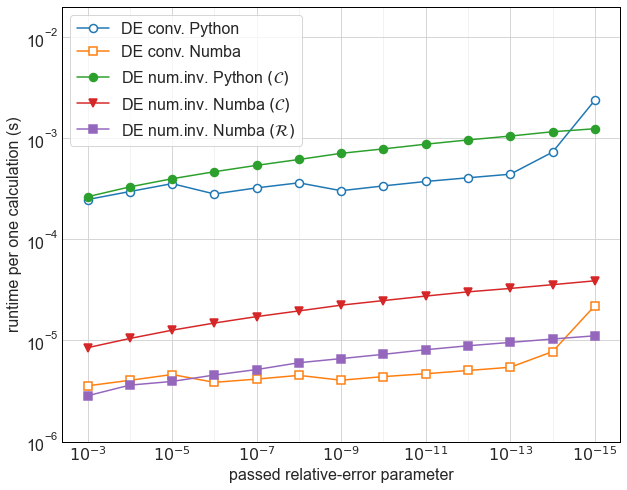

In [44]:
from matplotlib.ticker import MultipleLocator

plt.rcParams['font.size'] = '16'
plt.rcParams['lines.markersize'] = '8'

x = times.index

fig, ax = plt.subplots(figsize=(10,8))
for method, kwarg in Label.items():
    ax.plot(x,times[method], markeredgewidth=1.5, **kwarg)
ax.set_yscale('log')
ax.set_ylim(1e-6, 0.2e-1)

ax.set_xticks(range(3,16,2))
ax.set_xticklabels(['$10^{-'+str(n)+'}$' for n in range(3,16,2)])
#ax.set_yticklabels(['1e-'+str(n) for n in [6,5,4,]])
ax.set_xlabel('passed relative-error parameter')
ax.set_ylabel('runtime per one calculation (s)')


leg = ax.legend(frameon=True)

ax.minorticks_on()
minorXlocator = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorXlocator)
ax.grid(b=True, which='minor', axis='x', linestyle='-', alpha=0.3)

plt.setp(ax.spines.values(), color='black');

In [45]:
methods.keys()

dict_keys(['DE-conv', 'DE-conv-n', 'DE-numinv-c', 'DE-numinv-cn', 'DE-numin-n'])

In [46]:
ekwargs = [{'label':'DE conv. (Python, Numba)','marker':'o', 'markerfacecolor':'w'}, 
          {'label':'DE num.inv. (Python, Numba)', 'marker':'s'}]
eLabel = {key:kwarg for key, kwarg in zip(['DE-conv','DE-numin-n'], ekwargs)}

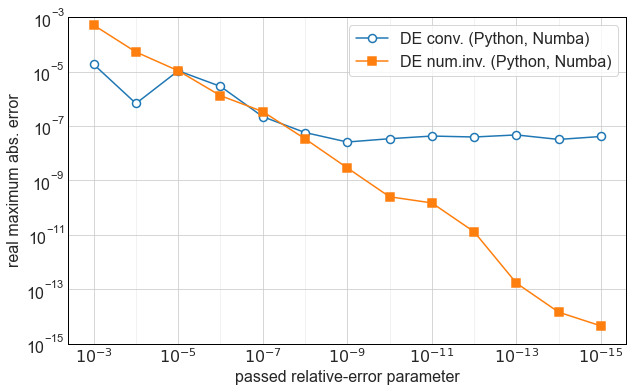

In [49]:
from matplotlib.ticker import MultipleLocator

plt.rcParams['font.size'] = '16'
plt.rcParams['lines.markersize'] = '8'

x = times.index

fig, ax = plt.subplots(figsize=(10,6))
for method, kwarg in eLabel.items():
    ax.plot(x,maxerrs[method], markeredgewidth=1.5, **kwarg)
ax.set_yscale('log')
ax.set_ylim(1e-15, 1e-3)

ax.set_xticks(range(3,16,2))
ax.set_xticklabels(['$10^{-'+str(n)+'}$' for n in range(3,16,2)])
#ax.set_yticklabels(['1e-'+str(n) for n in [6,5,4,]])
ax.set_xlabel('passed relative-error parameter')
ax.set_ylabel('real maximum abs. error')


leg = ax.legend(frameon=True)

ax.minorticks_on()
minorXlocator = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorXlocator)
ax.grid(b=True, which='minor', axis='x', linestyle='-', alpha=0.3)

plt.setp(ax.spines.values(), color='black');

In [48]:
# plot_kwargs = {'figsize':(10,7), 'fontsize':14}
# fig = times.plot(logy=True, ylim = (1e-6, 1e-3),  **plot_kwargs);

***
<a id=references></a>
# <font color=brown> References </font>
This notebook belongs to supplementary materials of the paper submitted to Journal of Statistical Computation and
Simulation and available at  <https://arxiv.org/abs/2105.04427>.
* Hančová, M., Gajdoš, A., Hanč, J. (2021). A practical, effective calculation of gamma difference distributions with open data science tools. arXiv:2105.04427 [cs, math, stat], https://arxiv.org/abs/2105.04427

### Abstract of the paper

At present, there is still no officially accepted and extensively verified implementation of computing the gamma difference distribution allowing unequal shape parameters. We explore four computational ways of the gamma difference distribution with the different shape parameters resulting from time series kriging, a forecasting approach based on the best linear unbiased prediction, and linear mixed models. The results of our numerical study, with emphasis on using open data science tools, demonstrate that our open tool implemented in high-performance Python(with Numba) is exponentially fast, highly accurate, and very reliable. It combines numerical inversion of the characteristic function and the trapezoidal rule with the double exponential oscillatory transformation (DE quadrature). At the double 53-bit precision, our tool outperformed the speed of the analytical computation based on Tricomi's $U(a, b, z)$ function in CAS software (commercial Mathematica, open SageMath) by 1.5-2 orders. At the precision of scientific numerical computational tools, it exceeded open SciPy, NumPy, and commercial MATLAB 5-10 times. The potential future application of our tool for a mixture of characteristic functions could open new possibilities for fast data analysis based on exact probability distributions in areas like multidimensional statistics, measurement uncertainty analysis in metrology as well as in financial mathematics and risk analysis. 